In [3]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import seaborn as sns
import re
sns.set_style("white")
%matplotlib inline

In [4]:
patient_1 = glob.glob(os.path.abspath(os.path.join('E:', 'Seizure_Data', 'train_1', '*.mat')))

In [131]:
os.path.basename(patient_1[0])

'1_1000_0.mat'

In [6]:
def mat_to_pandas(path):
    mat = loadmat(path)
    names = mat['dataStruct'].dtype.names
    ndata = {n: mat['dataStruct'][n][0, 0] for n in names}
    return pd.DataFrame(ndata['data'], columns=ndata['channelIndices'][0])    

In [7]:
df = mat_to_pandas(patient_1[0])
df2 = mat_to_pandas(patient_1[11])

In [8]:
df.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
0,12.677039,-45.829487,38.518459,-15.352544,21.565914,43.955376,43.04855,10.639985,3.597128,-28.171345,-7.290735,29.665182,-66.860695,-48.48632,-15.502208,17.739395
1,12.677039,-43.829487,37.518459,-17.352545,23.565914,44.955376,45.04855,10.639985,5.597128,-29.171345,-4.290735,23.665182,-64.860695,-49.48632,-19.502207,16.739395
2,14.677039,-40.829487,35.518459,-15.352544,25.565914,45.955376,47.04855,15.639985,6.597128,-28.171345,-0.290735,22.665182,-66.860695,-57.48632,-22.502207,17.739395
3,14.677039,-50.829487,31.518457,-11.352544,28.565914,44.955376,49.04855,18.639984,11.597128,-22.171345,-2.290735,22.665182,-70.860695,-59.48632,-24.502207,19.739395
4,18.677040,-55.829487,27.518457,-10.352544,28.565914,44.955376,49.04855,18.639984,8.597128,-18.171345,-1.290735,24.665182,-72.860695,-57.48632,-20.502207,18.739395


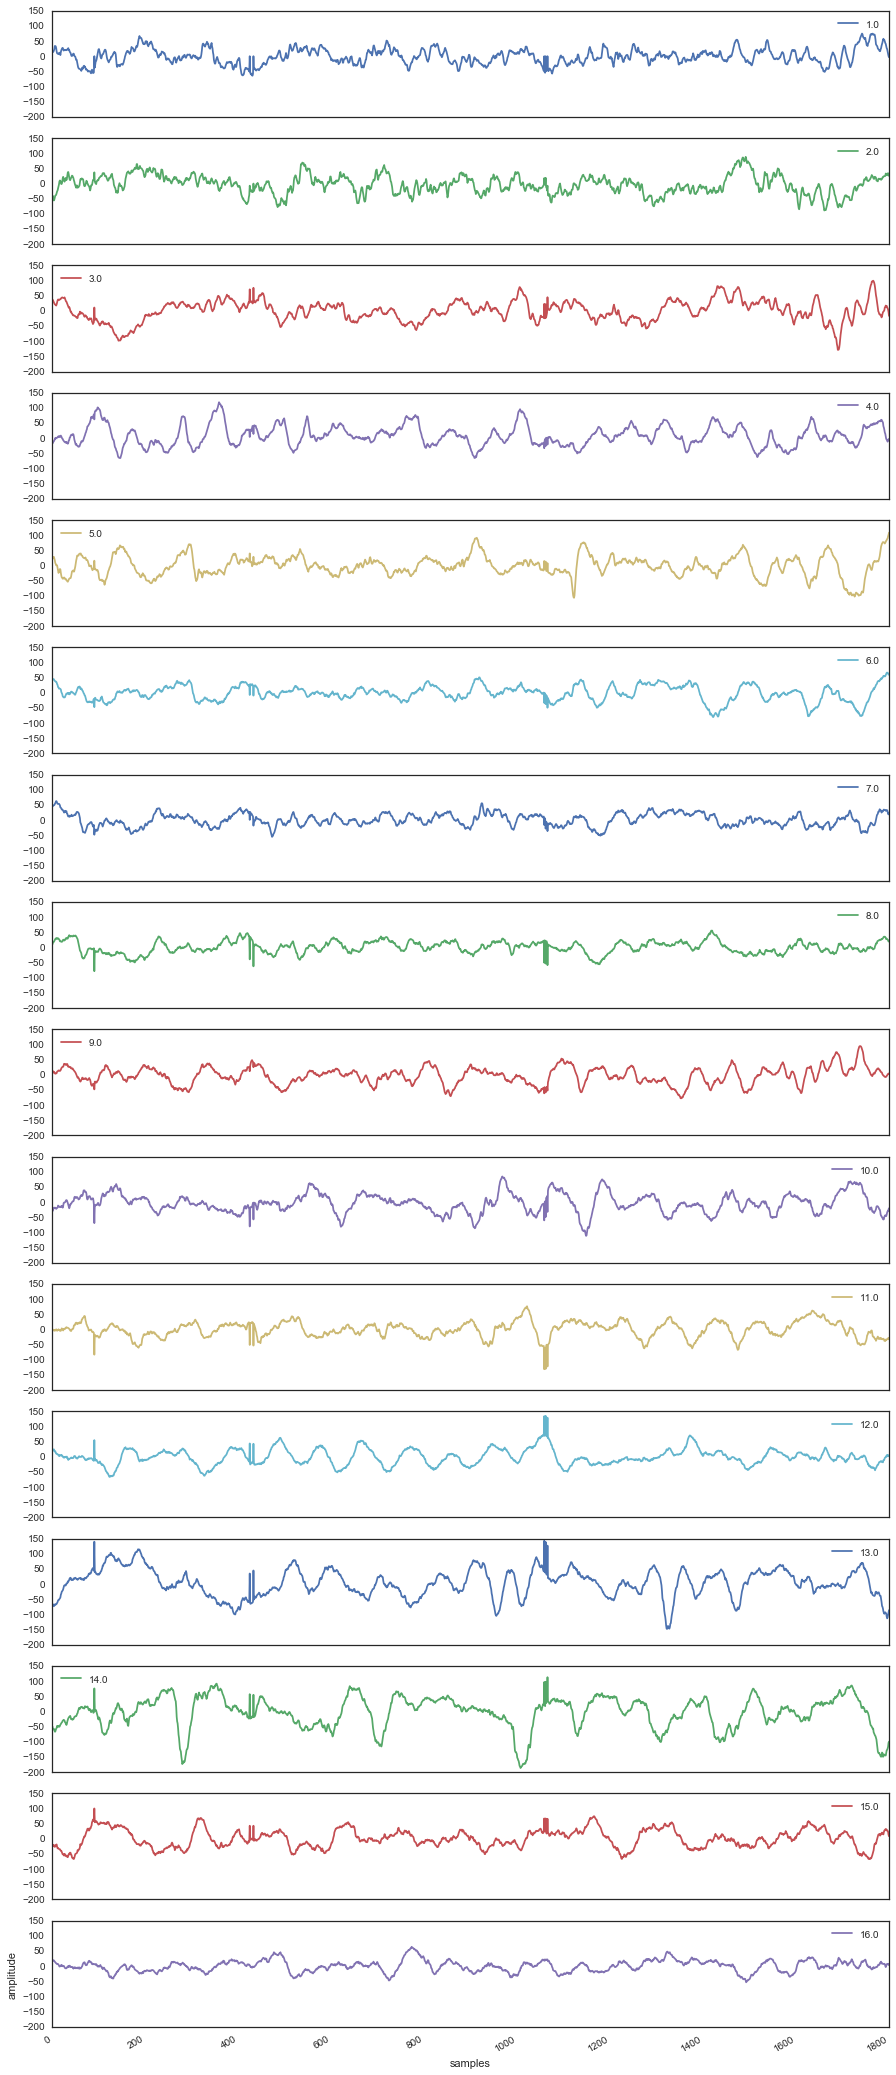

In [57]:
df[0:1800].plot(subplots=True, figsize=(15,40), sharex=True, sharey=True)
plt.xlabel('samples')
plt.ylabel('amplitude')
plt.show()

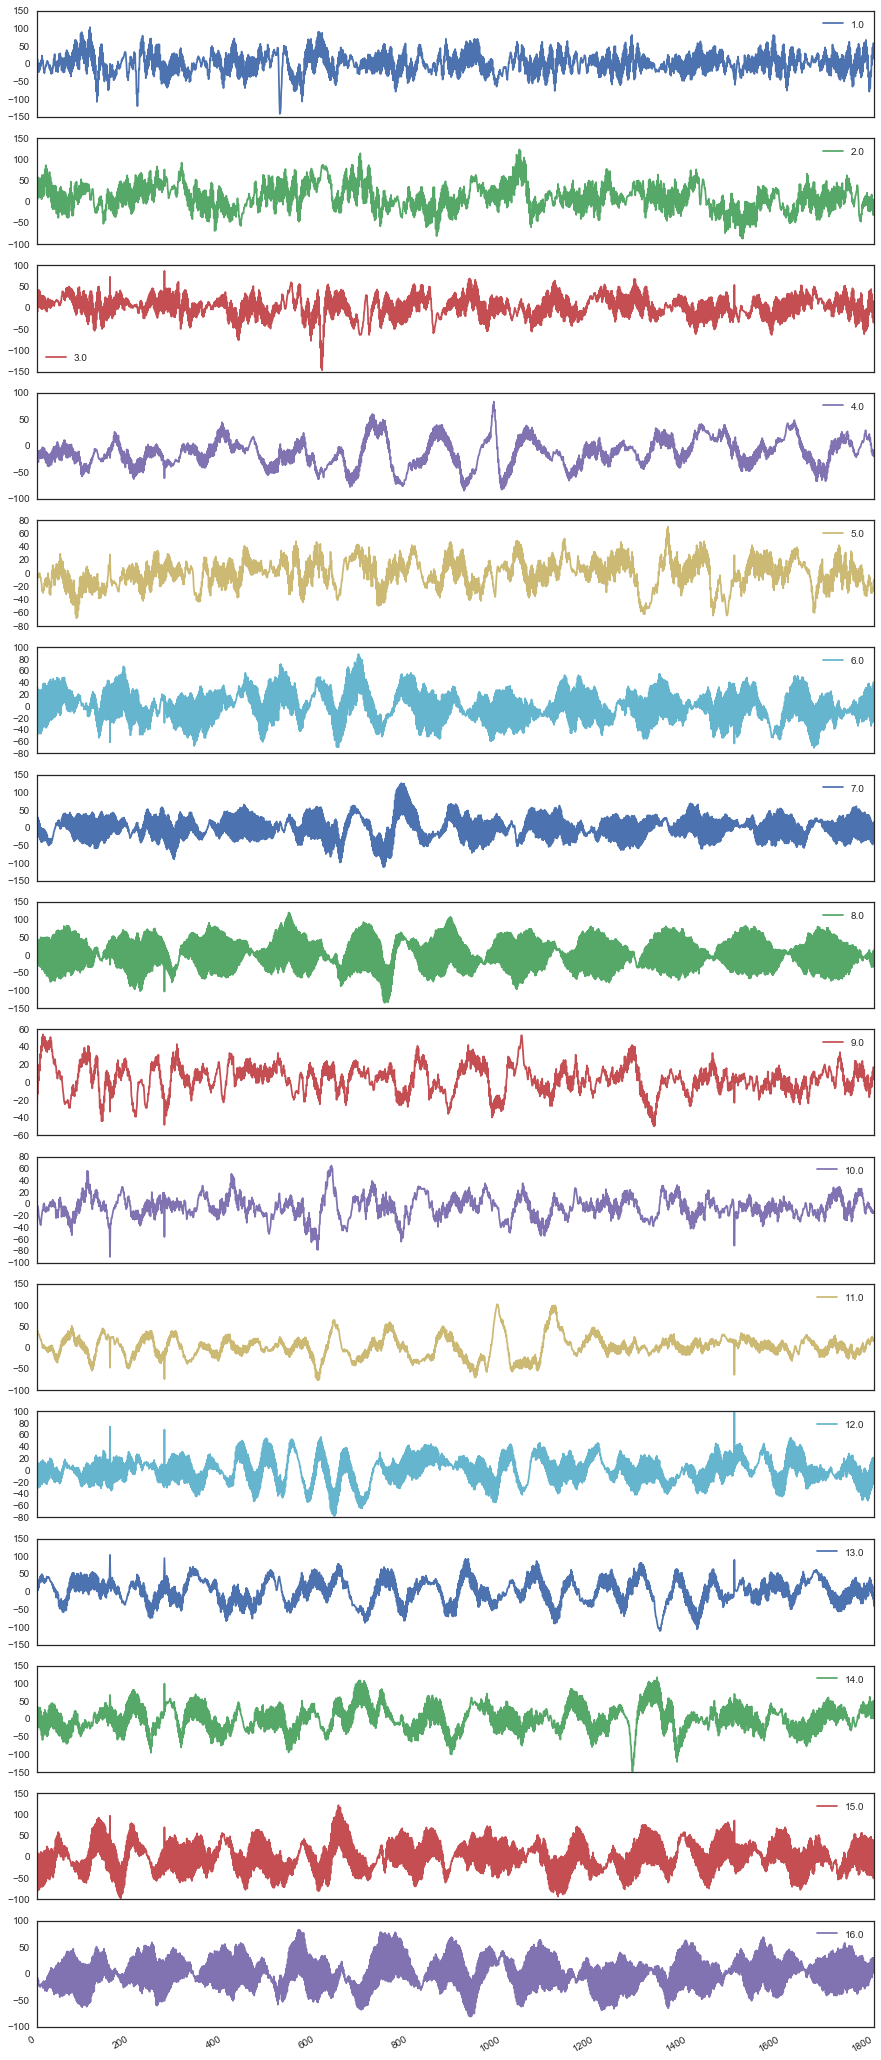

In [58]:
df2[0:1800].plot(subplots=True, figsize=(15,40))
plt.show()

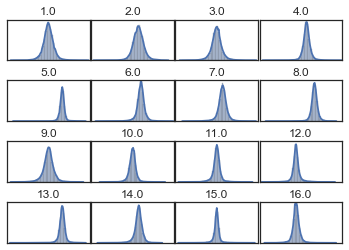

In [66]:
fig = plt.figure()

for col in df.columns:
    i = int(col)
    plt.subplots_adjust(wspace=.02, hspace=.5)
    ax = fig.add_subplot(4,4,i)
    sns.distplot(df[col])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(col)

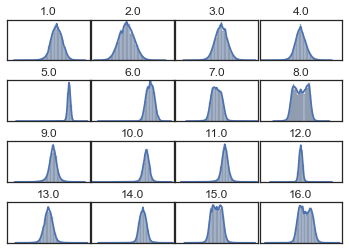

In [12]:
fig = plt.figure()

for col in df2.columns:
    i = int(col)
    plt.subplots_adjust(wspace=.02, hspace=.5)
    ax = fig.add_subplot(4,4,i)
    sns.distplot(df2[col])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(col)

In [13]:
df.describe().loc[['mean','std', 'min', 'max']]

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
mean,0.000013,0.018979,0.110020,-0.070512,0.121365,-0.086002,-0.047102,-0.205388,-0.123931,-0.229047,-0.245933,0.287039,0.369900,0.295848,0.203607,0.048189
std,38.211167,45.706164,52.032578,63.449481,58.839431,47.175754,37.482203,33.695529,50.692685,51.417274,57.203424,85.750028,69.802109,67.727398,65.477401,40.165204
min,-266.322968,-370.829498,-348.481537,-734.352539,-1063.434082,-540.044617,-334.951447,-527.359985,-357.402863,-470.171356,-548.290710,-747.334839,-1128.860718,-684.486328,-738.502197,-340.260590
max,283.677032,244.170517,373.518463,583.647461,503.565918,383.955383,276.048553,231.639984,328.597137,463.828644,511.709259,834.665161,505.139313,391.513672,731.497803,428.739410


In [14]:
df2.describe().loc[['mean','std', 'min', 'max']]

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
mean,0.000156,0.082317,0.219471,-0.062844,0.077141,-0.115376,0.016216,-0.312451,-0.078153,-0.214814,-0.224584,0.262993,0.307152,0.285710,0.223638,-0.066829
std,34.300165,31.374385,33.381969,39.705007,29.327620,32.469536,35.212285,48.251101,23.357806,23.422390,22.468556,27.499286,31.740264,36.602621,36.524438,32.190854
min,-250.567230,-130.888260,-198.811386,-289.699188,-1020.972595,-436.292511,-213.163773,-188.000000,-204.709824,-388.105286,-262.437073,-440.564972,-234.125793,-424.051971,-225.245941,-212.055298
max,165.432770,157.111740,179.000000,217.300812,351.027435,169.707504,286.836243,196.236343,169.290176,180.894730,190.562927,449.435028,275.874207,281.948029,270.754059,178.944702


In [15]:
fnames = os.listdir(os.path.abspath(os.path.join('E:', 'Seizure_Data', 'train_1')))

In [16]:
def get_label(path):
    '''
    splits file name into patient, sample, label
    '''
    fname = os.path.basename(path)
    split = re.sub('.mat', '', name).split('_')
    return split

In [17]:
labels = map(get_label, fnames)

In [18]:
labels_df = pd.DataFrame(labels, columns=['patient', 'sample', 'label'])

In [19]:
labels_df = labels_df.apply(pd.to_numeric).sort_values('sample')

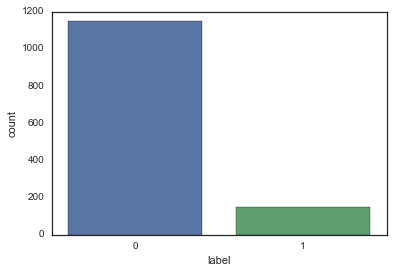

In [20]:
sns.countplot(labels_df['label'])

In [21]:
labels_df['label'].value_counts(normalize=True)

0    0.884793
1    0.115207
Name: label, dtype: float64

In [22]:
labels_df['label'].value_counts()

0    1152
1     150
Name: label, dtype: int64

In [23]:
df_fft = pd.DataFrame(np.fft.rfft(df))

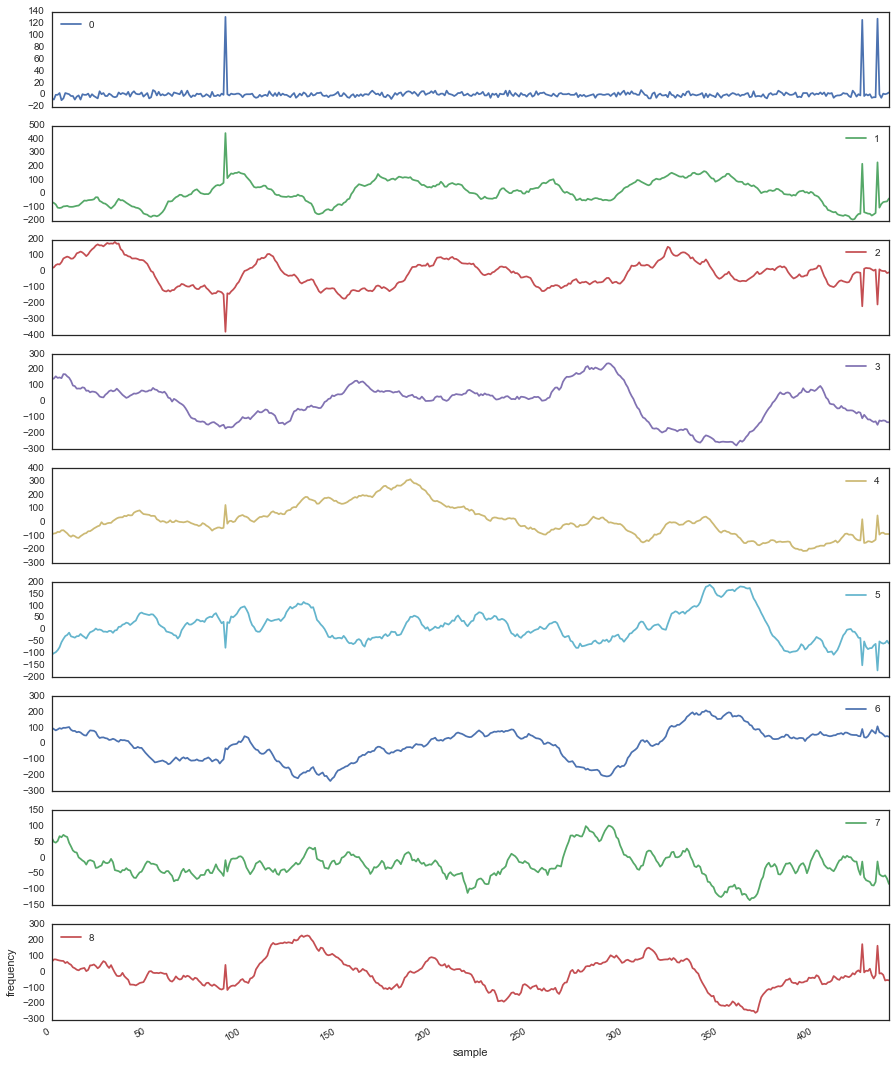

In [61]:
df_fft[0:440].plot(subplots=True, figsize=(15, 20))
plt.xlabel('sample')
plt.ylabel('frequency')
plt.show()

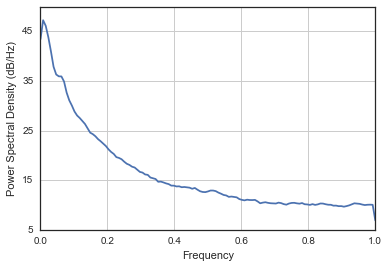

In [25]:
plt.psd(df[1.0])
plt.show()

In [26]:
def fft(time_data):
    return np.log10(np.absolute(np.fft.rfft(time_data)[:,1:48]))


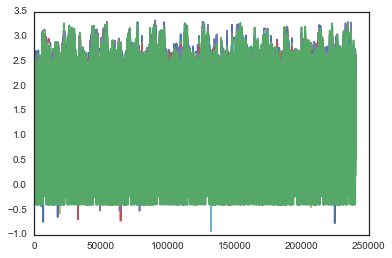

In [43]:
fft(df)

In [72]:
x, y = df[1.0], np.array([0])

try 1d conv net with average pooling per channel

In [73]:
from scipy import signal

In [90]:
X = pd.DataFrame(signal.resample(df, 600, window=400))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000004884908D0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000000488FFDE10>], dtype=object)

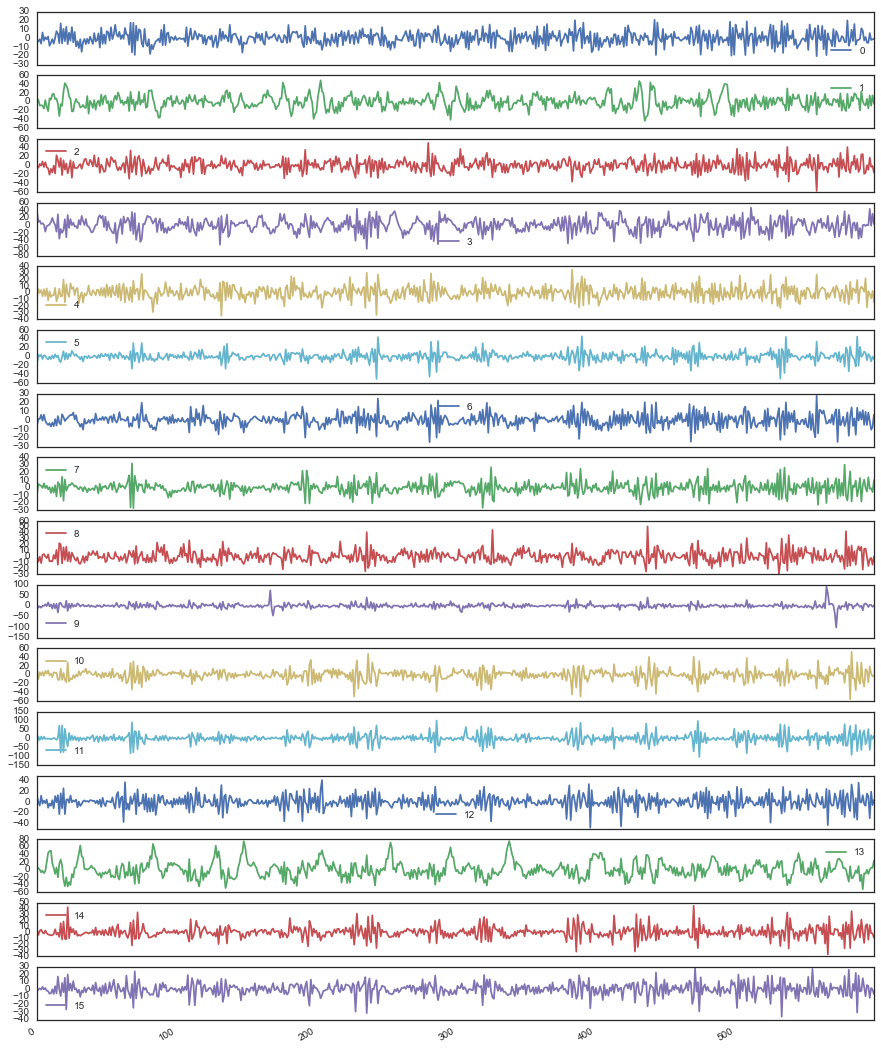

In [89]:
X.plot(subplots=True, figsize=(15, 20))

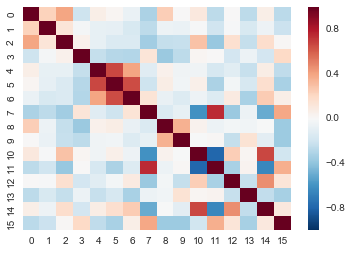

In [96]:
sns.heatmap(X.corr())

In [97]:
from sklearn.linear_model import LogisticRegression

In [107]:
X = X.values.flatten('F')

In [111]:
def preprocess(sample):
    return signal.resample(sample, 600, window=400).flatten('F')

In [112]:
X_neg = preprocess(df2)

In [118]:
X_train = np.array([X, X_neg])
X_train.shape

(2L, 9600L)

In [120]:
y = np.array([0, 1])

In [108]:
model = LogisticRegression(n_jobs=-1)

In [121]:
%time model.fit(X_train, y)

Wall time: 35 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [125]:
model.predict(X_train)
model.score(X_train, y)

1.0

In [100]:
test = np.array([[1, 2, 3], [4, 5, 6]])

In [101]:
test.shape

(2L, 3L)

In [102]:
test

array([[1, 2, 3],
       [4, 5, 6]])

In [105]:
test.flatten('F')

array([1, 4, 2, 5, 3, 6])